**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask']).float()

        return sample

In [3]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")

transform = transforms.Compose([
    transforms.ToTensor()
])

train_aug = A.Compose([
    #A.GaussNoise(
    #    var_limit=0.1,
    #    p=0.25),
    #A.VerticalFlip(p=0.1),
    #A.HorizontalFlip(p=0.3),
    #A.ShiftScaleRotate(
    #    shift_limit=0.09,
    #    rotate_limit=15,
    #    border_mode=0,
    #    p=0.25
    #),
    A.transforms.PadIfNeeded(
        min_height=572,
        min_width=572,
        border_mode=0
    ),
])

In [4]:
X_test = get_paths("data/test/images/")
y_test = get_paths("data/test/gt")

test_aug = A.Compose([
    A.transforms.PadIfNeeded(
        min_height=572,
        min_width=572,
        border_mode=0
    ),
])

In [5]:
train_dataset = RoadDataset(X_train, y_train, transform, aug=train_aug)
test_dataset = RoadDataset(X_test, y_test, transform, aug=test_aug)

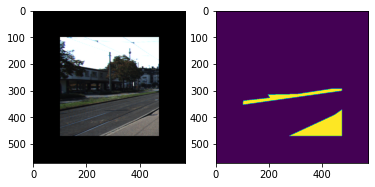

In [6]:
sample = train_dataset[0]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

In [7]:
image.shape

torch.Size([3, 572, 572])

In [8]:
mask.shape

torch.Size([1, 572, 572])

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [9]:
print(f"Train Dataset length {len(train_dataset)}")
print(f"Test Dataset length {len(test_dataset)}")

Train Dataset length 648
Test Dataset length 219


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [10]:
def calc_iou(prediction, ground_truth):
    eps = 1e-6
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / (union + eps)

In [11]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    new_images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    
    return new_images

## Part 1
### UNET

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [13]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
np.random.seed(0)

In [13]:
class Unet(nn.Module):
    def __init__(self, ):
        super().__init__()
        
        self.encoder_block_1 = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.pooling_1 = nn.MaxPool2d(2)
        
        self.encoder_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.pooling_2 = nn.MaxPool2d(2)
        
        self.encoder_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pooling_3 = nn.MaxPool2d(2)
        
        self.encoder_block_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pooling_4 = nn.MaxPool2d(2)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            nn.Conv2d(1024, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        
        self.upconv_1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        
        self.decoder_block_1 = nn.Sequential(
            nn.Conv2d(1024, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU()
        
        )
        self.upconv_2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.decoder_block_2 = nn.Sequential(
            nn.Conv2d(512, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU()
        
        )
        
        self.upconv_3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder_block_3 = nn.Sequential(
            nn.Conv2d(256, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upconv_4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.decoder_block_4 = nn.Sequential(
            nn.Conv2d(128, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.conv = nn.Conv2d(64, 1, 1)
        
    def forward(self, x):
        encoder_1 = self.encoder_block_1(x)
        encoder_2 = self.encoder_block_2(self.pooling_1(encoder_1))
        encoder_3 = self.encoder_block_3(self.pooling_2(encoder_2))
        encoder_4 = self.encoder_block_4(self.pooling_3(encoder_3))
        bottleneck = self.bottleneck(self.pooling_4(encoder_4))
        
        upsample_1 = self.upconv_1(bottleneck)
        decoder_1 = self.decoder_block_1(self.stack(encoder_4, upsample_1))
        upsample_2 = self.upconv_2(decoder_1)
        decoder_2 = self.decoder_block_2(self.stack(encoder_3, upsample_2))
        upsample_3 = self.upconv_3(decoder_2)
        decoder_3 = self.decoder_block_3(self.stack(encoder_2, upsample_3))
        upsample_4 = self.upconv_4(decoder_3)
        decoder_4 = self.decoder_block_4(self.stack(encoder_1, upsample_4))
        output = self.conv(decoder_4)
        
        return output
    
    def stack(self, encoder, decoder):
        encoder_size = encoder.shape[2]
        decoder_size = decoder.shape[2]
        
        start_index = (encoder_size - decoder_size) // 2
        
        slice_encoder = encoder[:, :,
                                start_index: decoder_size + start_index,
                                start_index: decoder_size + start_index,
                               ]
        
        output = torch.cat([slice_encoder, decoder], dim=1)
        
        return output
        

### Train

Create DataLoaders

In [13]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, 1, shuffle=False)

In [13]:
from torch.nn import functional as F

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [16]:
from tqdm import tqdm

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [18]:
def train(
    num_epochs,
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    threshold=0.5
):
    
    train_losses = []
    train_metrics = []
    best_test_iou = 0
    
    
    for epoch in tqdm(range(num_epochs)):
        train_loss_epoch = []
        train_metric_epoch = []
        test_loss_epoch = []
        test_metric_epoch = []
        model.train()
        for batch in train_dataloader:
            optimizer.zero_grad()
                
            images = batch['image']
            masks = batch['mask']
            
            images = images.to(device)
            masks = masks.to(device)
            
            
            output = model(images)
            logits = central_crop(output, 370)
            gt = central_crop(masks, 370)
            loss = criterion(logits, gt)
            loss.backward()
            optimizer.step()
                        
            train_loss_epoch.append(loss.item())
                      
            metric = calc_iou(F.sigmoid(logits).detach().cpu().numpy() > threshold,
                              gt.detach().cpu().numpy())
            train_metric_epoch.append(metric)
        
        model.eval()
        for batch in val_dataloader:
            images = batch['image']
            masks = batch['mask']
            
            images = images.to(device)
            masks = masks.to(device)
            
            output = model(images)
            logits = central_crop(output, 370)
            gt = central_crop(masks, 370)
            loss = criterion(logits, gt)
                      
            test_loss_epoch.append(loss.item())
            
            metric = calc_iou(F.sigmoid(logits).detach().cpu().numpy() > threshold,
                              gt.detach().cpu().numpy())
            test_metric_epoch.append(metric)
        print(f'Epoch {epoch + 1}')
        print(f' Train loss: {np.array(train_loss_epoch).mean()}; Train IoU: {np.array(train_metric_epoch).mean()}')
        print(f' Test loss: {np.array(test_loss_epoch).mean()}; Test IoU: {np.array(test_metric_epoch).mean()}')
        
        if best_test_iou < np.array(test_metric_epoch).mean():
            best_test_iou = np.array(test_metric_epoch).mean()
            
    print(f'Best IoU score on test: {best_test_iou}')

In [22]:
model = Unet().to(device)

In [23]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

Train without augmentations

In [24]:
train(
    num_epochs,
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
     )

  0%|          | 0/30 [00:00<?, ?it/s]/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
  3%|▎         | 1/30 [01:10<34:06, 70.58s/it]

Epoch 1
 Train loss: 0.46194110701723795; Train IoU: 0.5818510224247847
 Test loss: 0.6515372844591533; Test IoU: nan


  7%|▋         | 2/30 [02:21<33:01, 70.76s/it]

Epoch 2
 Train loss: 0.34126914419778964; Train IoU: 0.7043752276113397
 Test loss: 0.4708570489600369; Test IoU: 0.564684051935381


 10%|█         | 3/30 [03:32<31:51, 70.80s/it]

Epoch 3
 Train loss: 0.31130379874531816; Train IoU: 0.7217952727888268
 Test loss: 0.4357987612349802; Test IoU: 0.5782668346242397


 13%|█▎        | 4/30 [04:43<30:42, 70.85s/it]

Epoch 4
 Train loss: 0.2889664245814812; Train IoU: 0.7308883694328806
 Test loss: 0.4186073000028253; Test IoU: 0.6311275234634832


 17%|█▋        | 5/30 [05:54<29:30, 70.82s/it]

Epoch 5
 Train loss: 0.26616220357941417; Train IoU: 0.7530514678433138
 Test loss: 0.4114887123782885; Test IoU: 0.603804083465859


 20%|██        | 6/30 [07:04<28:17, 70.75s/it]

Epoch 6
 Train loss: 0.25206415100795465; Train IoU: 0.7601813637762262
 Test loss: 0.43551517376616666; Test IoU: 0.5510396936571967


 23%|██▎       | 7/30 [08:15<27:05, 70.67s/it]

Epoch 7
 Train loss: 0.2321383182595416; Train IoU: 0.7739833964398188
 Test loss: 0.38515940403829424; Test IoU: 0.6243540030038336


 27%|██▋       | 8/30 [09:25<25:54, 70.65s/it]

Epoch 8
 Train loss: 0.22648714955260113; Train IoU: 0.770800555583502
 Test loss: 0.3862720491134957; Test IoU: 0.6225262340606657


 30%|███       | 9/30 [10:36<24:42, 70.61s/it]

Epoch 9
 Train loss: 0.2148649910601174; Train IoU: 0.7782678400104192
 Test loss: 0.3621323797256435; Test IoU: 0.6577633908953235


 33%|███▎      | 10/30 [11:46<23:32, 70.60s/it]

Epoch 10
 Train loss: 0.19697271759917095; Train IoU: 0.7983089958885068
 Test loss: 0.3594154511412529; Test IoU: 0.6661278927708357


 37%|███▋      | 11/30 [12:57<22:21, 70.59s/it]

Epoch 11
 Train loss: 0.18555576481470248; Train IoU: 0.80296960015398
 Test loss: 0.35567398240032805; Test IoU: 0.6729451632075781


 40%|████      | 12/30 [14:07<21:10, 70.57s/it]

Epoch 12
 Train loss: 0.17940229032097793; Train IoU: 0.8070762309129913
 Test loss: 0.33282224228393; Test IoU: 0.6781782122726058


 43%|████▎     | 13/30 [15:18<20:00, 70.61s/it]

Epoch 13
 Train loss: 0.16887478421374066; Train IoU: 0.8159853271993501
 Test loss: 0.33290135343325195; Test IoU: 0.6791263729678018


 47%|████▋     | 14/30 [16:29<18:49, 70.61s/it]

Epoch 14
 Train loss: 0.15649040879272832; Train IoU: 0.8257045520314586
 Test loss: 0.31304157896128965; Test IoU: 0.6767273598389074


 50%|█████     | 15/30 [17:39<17:39, 70.65s/it]

Epoch 15
 Train loss: 0.1449939274206394; Train IoU: 0.8372945906152034
 Test loss: 0.3037193975492155; Test IoU: 0.697946826284074


 53%|█████▎    | 16/30 [18:50<16:29, 70.65s/it]

Epoch 16
 Train loss: 0.14085282058250614; Train IoU: 0.8378174563925037
 Test loss: 0.30154220562547307; Test IoU: 0.6930833437624861


 57%|█████▋    | 17/30 [20:00<15:15, 70.40s/it]

Epoch 17
 Train loss: 0.130212466891219; Train IoU: 0.8495489251515406
 Test loss: 0.2889736115115963; Test IoU: 0.7064362067143416


 60%|██████    | 18/30 [21:11<14:05, 70.46s/it]

Epoch 18
 Train loss: 0.12215742396145332; Train IoU: 0.8587981757252887
 Test loss: 0.2667760481573131; Test IoU: 0.7264292102490378


 63%|██████▎   | 19/30 [22:21<12:54, 70.37s/it]

Epoch 19
 Train loss: 0.1215108516739636; Train IoU: 0.8579027146958059
 Test loss: 0.2790780149094046; Test IoU: 0.7069951205292021


 67%|██████▋   | 20/30 [23:30<11:41, 70.15s/it]

Epoch 20
 Train loss: 0.1157325375370863; Train IoU: 0.8599876271823885
 Test loss: 0.3263154557850807; Test IoU: 0.6261631147979151


 70%|███████   | 21/30 [24:40<10:31, 70.13s/it]

Epoch 21
 Train loss: 0.11272194618132056; Train IoU: 0.8584938011395342
 Test loss: 0.28824157284819374; Test IoU: 0.681210186511


 73%|███████▎  | 22/30 [25:51<09:21, 70.18s/it]

Epoch 22
 Train loss: 0.11145056311677141; Train IoU: 0.8566089573000054
 Test loss: 0.24686004445977408; Test IoU: 0.7368491972745389


 77%|███████▋  | 23/30 [27:01<08:11, 70.18s/it]

Epoch 23
 Train loss: 0.10190814878882432; Train IoU: 0.8706379768861225
 Test loss: 0.25506672494487675; Test IoU: 0.7203553922562749


 80%|████████  | 24/30 [28:11<07:01, 70.19s/it]

Epoch 24
 Train loss: 0.11658704862362002; Train IoU: 0.842579231412874
 Test loss: 0.2704311184687157; Test IoU: 0.7112026292976398


 83%|████████▎ | 25/30 [29:22<05:51, 70.29s/it]

Epoch 25
 Train loss: 0.10122642720617898; Train IoU: 0.8633320203056905
 Test loss: 0.2595850226541632; Test IoU: 0.7196285467231063


 87%|████████▋ | 26/30 [30:32<04:41, 70.26s/it]

Epoch 26
 Train loss: 0.09260235181668909; Train IoU: 0.8759485891817412
 Test loss: 0.24475061675729273; Test IoU: 0.7268542946585883


 90%|█████████ | 27/30 [31:42<03:30, 70.17s/it]

Epoch 27
 Train loss: 0.08694913619902075; Train IoU: 0.8848061649790605
 Test loss: 0.24697398023518252; Test IoU: 0.7170437056818088


 93%|█████████▎| 28/30 [32:52<02:20, 70.15s/it]

Epoch 28
 Train loss: 0.08109757813011728; Train IoU: 0.8923694653312746
 Test loss: 0.2434478162630508; Test IoU: 0.7283974458986814


 97%|█████████▋| 29/30 [34:01<01:09, 69.98s/it]

Epoch 29
 Train loss: 0.07519649587026457; Train IoU: 0.8997338580186065
 Test loss: 0.2168087970176244; Test IoU: 0.757153601558181


100%|██████████| 30/30 [35:11<00:00, 70.38s/it]

Epoch 30
 Train loss: 0.08450994549728022; Train IoU: 0.8815803246323812
 Test loss: 0.223882695583448; Test IoU: 0.7464190424956613
Best IoU score on test: 0.757153601558181


#### Results
 1) Unet without augmentations: lr=1e-4; 30 epoch; IoU: 0.757153601558181 </br>
 2) Unet with augmentations - shit

## Part 2
### DeepLabV3 +

In [20]:
#add augmentations
#train new model from segmentation models pytorch (deeplab or fpn)

In [19]:
train_aug = A.Compose([
    A.GaussNoise(
        var_limit=0.1,
        p=0.2),
    #A.VerticalFlip(p=0.1),
    A.HorizontalFlip(p=0.15),
    A.ShiftScaleRotate(
        shift_limit=0.09,
        rotate_limit=15,
        border_mode=0,
        p=0.15
    ),
    A.transforms.PadIfNeeded(
        min_height=576,
        min_width=576,
        border_mode=0
    ),
])

test_aug = A.Compose([
    A.transforms.PadIfNeeded(
        min_height=576,
        min_width=576,
        border_mode=0
    ),
])

In [20]:
train_dataset = RoadDataset(X_train, y_train, transform, aug=train_aug)
test_dataset = RoadDataset(X_test, y_test, transform, aug=test_aug)

In [21]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, 1, shuffle=False)

In [22]:
import segmentation_models_pytorch as smp

In [23]:
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',).to(device)

In [24]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 60

In [25]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [26]:
train(
    num_epochs,
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
     )

  0%|          | 0/60 [00:00<?, ?it/s]/home/kozunov/courses/dvag/env/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  2%|▏         | 1/60 [00:33<32:53, 33.45s/it]

Epoch 1
 Train loss: 0.31793802249722364; Train IoU: 0.6438344667612311
 Test loss: 0.3390328794309538; Test IoU: 0.6542948395610753


  3%|▎         | 2/60 [01:07<32:51, 33.98s/it]

Epoch 2
 Train loss: 0.15105148059565845; Train IoU: 0.7739737974177345
 Test loss: 0.2209519964374908; Test IoU: 0.7363329691523762


  5%|▌         | 3/60 [01:42<32:25, 34.13s/it]

Epoch 3
 Train loss: 0.11360560393914944; Train IoU: 0.819803833973017
 Test loss: 0.20170349535876758; Test IoU: 0.7585137720214594


  7%|▋         | 4/60 [02:16<32:06, 34.39s/it]

Epoch 4
 Train loss: 0.09722394914161868; Train IoU: 0.8400949579249529
 Test loss: 0.20014485240526939; Test IoU: 0.760942829974685


  8%|▊         | 5/60 [02:51<31:38, 34.52s/it]

Epoch 5
 Train loss: 0.08418207052277356; Train IoU: 0.8598238331027708
 Test loss: 0.16727099788787703; Test IoU: 0.7923401127439195


 10%|█         | 6/60 [03:26<31:13, 34.69s/it]

Epoch 6
 Train loss: 0.07157535087771533; Train IoU: 0.8782082511414917
 Test loss: 0.17251721391939137; Test IoU: 0.7794753445548849


 12%|█▏        | 7/60 [04:01<30:35, 34.64s/it]

Epoch 7
 Train loss: 0.07437976104457204; Train IoU: 0.8726287262969722
 Test loss: 0.15793026282907077; Test IoU: 0.7984524301907494


 13%|█▎        | 8/60 [04:35<30:03, 34.69s/it]

Epoch 8
 Train loss: 0.07312863919793106; Train IoU: 0.8726466973486072
 Test loss: 0.1427859106020296; Test IoU: 0.8088219745077743


 15%|█▌        | 9/60 [05:10<29:27, 34.66s/it]

Epoch 9
 Train loss: 0.06730942028324778; Train IoU: 0.8821330706947124
 Test loss: 0.1594756057817642; Test IoU: 0.7907426553417097


 17%|█▋        | 10/60 [05:44<28:36, 34.33s/it]

Epoch 10
 Train loss: 0.06340145337872388; Train IoU: 0.8883755338840157
 Test loss: 0.13195424809303458; Test IoU: 0.8186986967007492


 18%|█▊        | 11/60 [06:17<27:52, 34.13s/it]

Epoch 11
 Train loss: 0.05722001558396875; Train IoU: 0.8983863930857104
 Test loss: 0.12628444035847983; Test IoU: 0.827413341946517


 20%|██        | 12/60 [06:51<27:17, 34.11s/it]

Epoch 12
 Train loss: 0.05079565397123011; Train IoU: 0.9093094836215658
 Test loss: 0.14100212865768502; Test IoU: 0.8096406543094449


 22%|██▏       | 13/60 [07:25<26:38, 34.02s/it]

Epoch 13
 Train loss: 0.053336627599669666; Train IoU: 0.9049030324557289
 Test loss: 0.11783465947190376; Test IoU: 0.835888152865585


 23%|██▎       | 14/60 [08:00<26:10, 34.15s/it]

Epoch 14
 Train loss: 0.04685660397134176; Train IoU: 0.9160790029626434
 Test loss: 0.10694292255732567; Test IoU: 0.850209008348824


 25%|██▌       | 15/60 [08:35<25:49, 34.43s/it]

Epoch 15
 Train loss: 0.0426328182220459; Train IoU: 0.9232076466273538
 Test loss: 0.11468773508725101; Test IoU: 0.8404712559190287


 27%|██▋       | 16/60 [09:09<25:08, 34.27s/it]

Epoch 16
 Train loss: 0.04341961843211476; Train IoU: 0.9216698825698147
 Test loss: 0.10896421077588922; Test IoU: 0.8471671720146965


 28%|██▊       | 17/60 [09:43<24:36, 34.33s/it]

Epoch 17
 Train loss: 0.04469752602460908; Train IoU: 0.9192688420093258
 Test loss: 0.11656527187181934; Test IoU: 0.8352258101278619


 30%|███       | 18/60 [10:18<24:06, 34.44s/it]

Epoch 18
 Train loss: 0.04062466941228727; Train IoU: 0.9261513830485697
 Test loss: 0.10405839795935644; Test IoU: 0.8506807766092757


 32%|███▏      | 19/60 [10:53<23:38, 34.60s/it]

Epoch 19
 Train loss: 0.03670928972523387; Train IoU: 0.9330972828521676
 Test loss: 0.10570542507520005; Test IoU: 0.849164688312271


 33%|███▎      | 20/60 [11:27<23:01, 34.54s/it]

Epoch 20
 Train loss: 0.038772830149022545; Train IoU: 0.9294985266485017
 Test loss: 0.1101915262061167; Test IoU: 0.8411189513353349


 35%|███▌      | 21/60 [12:03<22:39, 34.85s/it]

Epoch 21
 Train loss: 0.042279217301345456; Train IoU: 0.9227313402404039
 Test loss: 0.10373787166865449; Test IoU: 0.8495518723383628


 37%|███▋      | 22/60 [12:38<22:13, 35.08s/it]

Epoch 22
 Train loss: 0.04172189206611819; Train IoU: 0.9234969410540325
 Test loss: 0.09984818604438817; Test IoU: 0.8549992968925493


 38%|███▊      | 23/60 [13:14<21:41, 35.16s/it]

Epoch 23
 Train loss: 0.037611797088530005; Train IoU: 0.9309442534683267
 Test loss: 0.09743110719881101; Test IoU: 0.8573018692176414


 40%|████      | 24/60 [13:49<21:01, 35.05s/it]

Epoch 24
 Train loss: 0.036533474922180176; Train IoU: 0.9326043333983112
 Test loss: 0.09811545017103082; Test IoU: 0.8563184721009611


 42%|████▏     | 25/60 [14:23<20:21, 34.91s/it]

Epoch 25
 Train loss: 0.03159396095973689; Train IoU: 0.9418151135848144
 Test loss: 0.09906806085752026; Test IoU: 0.8554015205800685


 43%|████▎     | 26/60 [14:58<19:42, 34.77s/it]

Epoch 26
 Train loss: 0.04004457084144034; Train IoU: 0.9262542569201949
 Test loss: 0.1566643616924547; Test IoU: 0.7837351831047027


 45%|████▌     | 27/60 [15:32<19:05, 34.70s/it]

Epoch 27
 Train loss: 0.050012584139661094; Train IoU: 0.9084283027231144
 Test loss: 0.11739955046405531; Test IoU: 0.8330409669955356


 47%|████▋     | 28/60 [16:06<18:20, 34.40s/it]

Epoch 28
 Train loss: 0.039956001246847755; Train IoU: 0.926407822130692
 Test loss: 0.11130981684819749; Test IoU: 0.8403154284089982


 48%|████▊     | 29/60 [16:40<17:41, 34.25s/it]

Epoch 29
 Train loss: 0.03543719867380654; Train IoU: 0.9346285804194951
 Test loss: 0.10569780411785595; Test IoU: 0.8436965123553587


 50%|█████     | 30/60 [17:13<17:02, 34.10s/it]

Epoch 30
 Train loss: 0.030912368762783887; Train IoU: 0.9425815321952886
 Test loss: 0.09370982347558078; Test IoU: 0.862543951562203


 52%|█████▏    | 31/60 [17:49<16:40, 34.51s/it]

Epoch 31
 Train loss: 0.03065074217028734; Train IoU: 0.9429192249106995
 Test loss: 0.0994308531012165; Test IoU: 0.8556991865387015


 53%|█████▎    | 32/60 [18:23<16:03, 34.42s/it]

Epoch 32
 Train loss: 0.02874933364914685; Train IoU: 0.9465328317009049
 Test loss: 0.10448947616908104; Test IoU: 0.8510298820893746


 55%|█████▌    | 33/60 [18:57<15:23, 34.19s/it]

Epoch 33
 Train loss: 0.032175756082302186; Train IoU: 0.9403205989577864
 Test loss: 0.09152667135952815; Test IoU: 0.8651177345221479


 57%|█████▋    | 34/60 [19:31<14:49, 34.22s/it]

Epoch 34
 Train loss: 0.030182637819429724; Train IoU: 0.9437040447095295
 Test loss: 0.09393232598152335; Test IoU: 0.8617806340464158


 58%|█████▊    | 35/60 [20:05<14:12, 34.12s/it]

Epoch 35
 Train loss: 0.029439997382280304; Train IoU: 0.945140581773338
 Test loss: 0.09337531023373886; Test IoU: 0.863044539009492


 60%|██████    | 36/60 [20:39<13:37, 34.07s/it]

Epoch 36
 Train loss: 0.026659304048956896; Train IoU: 0.9501922825190459
 Test loss: 0.10209460155060303; Test IoU: 0.8507183340503035


 62%|██████▏   | 37/60 [21:13<13:02, 34.00s/it]

Epoch 37
 Train loss: 0.027808804337571307; Train IoU: 0.9480883473001204
 Test loss: 0.09983043882944813; Test IoU: 0.8531032957661745


 63%|██████▎   | 38/60 [21:46<12:26, 33.91s/it]

Epoch 38
 Train loss: 0.027225822937197802; Train IoU: 0.9490920600511511
 Test loss: 0.10084082628493984; Test IoU: 0.8528940330092518


 65%|██████▌   | 39/60 [22:21<11:54, 34.00s/it]

Epoch 39
 Train loss: 0.027043082365175573; Train IoU: 0.9494439350010334
 Test loss: 0.09452323908130872; Test IoU: 0.8611398957577199


 67%|██████▋   | 40/60 [22:55<11:19, 34.00s/it]

Epoch 40
 Train loss: 0.0266933295784927; Train IoU: 0.9501410874184758
 Test loss: 0.1004912953942878; Test IoU: 0.8520352476536006


 68%|██████▊   | 41/60 [23:29<10:47, 34.08s/it]

Epoch 41
 Train loss: 0.025448646487259283; Train IoU: 0.9521853064233757
 Test loss: 0.09637229083335563; Test IoU: 0.8584549064571304


 70%|███████   | 42/60 [24:03<10:12, 34.04s/it]

Epoch 42
 Train loss: 0.024801928822587176; Train IoU: 0.9533656969232073
 Test loss: 0.1032769922252115; Test IoU: 0.8498445889859528


 72%|███████▏  | 43/60 [24:37<09:37, 33.95s/it]

Epoch 43
 Train loss: 0.023443589850169855; Train IoU: 0.9561370214177322
 Test loss: 0.10839030105773717; Test IoU: 0.846204198349759


 73%|███████▎  | 44/60 [25:11<09:04, 34.05s/it]

Epoch 44
 Train loss: 0.02291349957628948; Train IoU: 0.9569316288650106
 Test loss: 0.09775669226363369; Test IoU: 0.8563756659487483


 75%|███████▌  | 45/60 [25:45<08:29, 33.98s/it]

Epoch 45
 Train loss: 0.021779230455072913; Train IoU: 0.9591592862645621
 Test loss: 0.09714030457413904; Test IoU: 0.8592283777193324


 77%|███████▋  | 46/60 [26:19<07:57, 34.10s/it]

Epoch 46
 Train loss: 0.02225391603097683; Train IoU: 0.9581972148873477
 Test loss: 0.09678802724298277; Test IoU: 0.8577400364445634


 78%|███████▊  | 47/60 [26:53<07:22, 34.02s/it]

Epoch 47
 Train loss: 0.022196838041631188; Train IoU: 0.9582901950345314
 Test loss: 0.10211481786754033; Test IoU: 0.8503548344991578


 80%|████████  | 48/60 [27:27<06:47, 33.94s/it]

Epoch 48
 Train loss: 0.022751127801290374; Train IoU: 0.9572307780355845
 Test loss: 0.09739473013028707; Test IoU: 0.8586471221903047


 82%|████████▏ | 49/60 [28:00<06:12, 33.83s/it]

Epoch 49
 Train loss: 0.021704364113691376; Train IoU: 0.9592331006064868
 Test loss: 0.09984167280806798; Test IoU: 0.855747432325334


 83%|████████▎ | 50/60 [28:34<05:38, 33.84s/it]

Epoch 50
 Train loss: 0.02056297587185371; Train IoU: 0.9612631646245247
 Test loss: 0.09512153254252047; Test IoU: 0.8601582124656766


 85%|████████▌ | 51/60 [29:08<05:05, 33.95s/it]

Epoch 51
 Train loss: 0.021550322451242585; Train IoU: 0.9593242070199253
 Test loss: 0.09208431717467634; Test IoU: 0.8642131605384025


 87%|████████▋ | 52/60 [29:42<04:31, 33.96s/it]

Epoch 52
 Train loss: 0.019848867160517994; Train IoU: 0.9625736278277163
 Test loss: 0.0968996188411974; Test IoU: 0.8587937790529077


 88%|████████▊ | 53/60 [30:16<03:57, 33.87s/it]

Epoch 53
 Train loss: 0.022398896333647937; Train IoU: 0.9578111402222522
 Test loss: 0.1090817386156892; Test IoU: 0.8402907393517739


 90%|█████████ | 54/60 [30:50<03:22, 33.80s/it]

Epoch 54
 Train loss: 0.02087167995732005; Train IoU: 0.9606195754258383
 Test loss: 0.08506821851207785; Test IoU: 0.8736673165210467


 92%|█████████▏| 55/60 [31:23<02:49, 33.81s/it]

Epoch 55
 Train loss: 0.019976612998218072; Train IoU: 0.962372440187475
 Test loss: 0.10486031422331997; Test IoU: 0.8492331642663548


 93%|█████████▎| 56/60 [31:57<02:15, 33.79s/it]

Epoch 56
 Train loss: 0.026839595015456037; Train IoU: 0.9495168434573993
 Test loss: 0.11601136481925232; Test IoU: 0.8289564288984802


 95%|█████████▌| 57/60 [32:32<01:41, 33.97s/it]

Epoch 57
 Train loss: 0.025669109530565216; Train IoU: 0.9515919851028011
 Test loss: 0.10408844169416384; Test IoU: 0.8481356256275713


 97%|█████████▋| 58/60 [33:05<01:07, 33.84s/it]

Epoch 58
 Train loss: 0.02469652745781875; Train IoU: 0.9532438635056307
 Test loss: 0.11390922521347324; Test IoU: 0.8364885944094623


 98%|█████████▊| 59/60 [33:39<00:33, 33.76s/it]

Epoch 59
 Train loss: 0.022208782230935444; Train IoU: 0.9580706471777681
 Test loss: 0.103825359856157; Test IoU: 0.8493056163478173


100%|██████████| 60/60 [34:12<00:00, 34.22s/it]

Epoch 60
 Train loss: 0.021470330110410364; Train IoU: 0.9592721853248025
 Test loss: 0.09932184001626489; Test IoU: 0.8531404948825618
Best IoU score on test: 0.8736673165210467
